In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
from __future__ import division
from glob import glob
import os
import time
import cPickle as pickle

import scipy.linalg
import scipy.stats

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.io.fits
import astropy.table
import astropy.units as u
import astropy.constants as c
import astropy.time

import emcee
import numdifftools

import kepler
import threebody

In [4]:
!ls -ltr *.tim

-rw-r--r-- 1 aarchiba pulsar     3194 May 31  2013 0337-short-2.tim
-rw-r--r-- 1 aarchiba pulsar  1709289 May 31  2013 0337+17.tim
-rw-r--r-- 1 aarchiba pulsar    10646 May 31  2013 0337-short.tim
-rw-r--r-- 1 aarchiba pulsar  1870476 Jun 17  2013 0337+17-scott-2013-06-06.tim
-rw-r--r-- 1 aarchiba pulsar  6961347 Jul 31  2013 synthetic.tim
-rw-r--r-- 1 aarchiba pulsar  1977505 Aug 15  2013 0337+17-scott-2013-08-15.tim
-rw-r--r-- 1 aarchiba pulsar  2043963 Aug 30  2013 0337+17-scott-2013-08-29.tim
-rw-r--r-- 1 aarchiba pulsar  1590000 Sep 19  2013 fake-pulsar.tim
-rw-r--r-- 1 aarchiba pulsar  2078907 Jan 22  2014 0337+17-scott-2014-01-22.tim
-rw-r--r-- 1 aarchiba pulsar  2201549 Jan 28  2014 0337+17-anne-2014-01-28.tim
-rw-r--r-- 1 aarchiba pulsar      154 Feb  4  2014 0337+17-anne-2014-02-04.tim
-rw-r--r-- 1 aarchiba pulsar  2186806 Feb  4  2014 0337+17-anne-2014-02-04b.tim
-rw-r--r-- 1 aarchiba pulsar  2143978 Feb 10  2014 fake-t2.tim
-rw-r--r-- 1 aarchiba pulsar 54000000 Mar 24  2014

In [5]:
!ls -ltr toas/*/*.tim

-rw-r--r-- 1 aarchiba pulsar 2078907 Jan 22  2014 toas/gbt/0337+17-scott-2014-01-22.tim
-rw-r--r-- 1 aarchiba pulsar  898938 Feb  4  2014 toas/gbt/L-band-scott-2014-02-04.tim
-rw-rw-r-- 1 aarchiba pulsar  174978 Feb  4  2014 toas/wsrt/L-band-anne-2014-02-04.tim
-rw-rw-r-- 1 aarchiba pulsar 1112898 Feb  4  2014 toas/ao/L-band-anne-2014-02-04.tim
-rw-r--r-- 1 aarchiba pulsar  898928 Feb 12  2014 toas/gbt/L-band-scott-2014-02-04-nojump.tim
-rw-rw-r-- 1 aarchiba pulsar  116372 Mar 19  2014 toas/gbt/L-band-2d-scott-2014-03-03.tim
-rw-r----- 1 aarchiba pulsar 1116480 Sep 22  2014 toas/gbt/L-band-scott-2014-08-12.tim


In [54]:
# If we're using tempo1 format files the loader can correctly identify telescope and band
# So really we're just concatenating these files
timfiles = [
    ['0337+1715_GUPPI_Lband_fscr_t1.tim', 'GBT1500'],
    ['toas/wsrt/L-band-anne-2014-02-04.tim', 'WSRT1400'],
    ['toas/ao/L-band-anne-2014-02-04.tim','AO1350'],
    ]
outname = '0337+17-anne-2016-09-26'

firstchars = {}
with open(outname+".tim", "wt") as f:
    for (t,tel) in timfiles:
        f.write("C %s\n" % t)
    for (t,tel) in timfiles:
        skipping = False
        for l in open(t,"rt").readlines():
            if l.startswith("SKIP"):
                if skipping: 
                    raise ValueError
                skipping = True
            elif l.startswith("NOSKIP"):
                if not skipping: 
                    raise ValueError
                skipping = False
            elif l.startswith("EMAX"):
                pass
            else:
                # Maybe strip comments?
                if not skipping:
                    if l[0] not in firstchars:
                        firstchars[l[0]] = 0
                    firstchars[l[0]] += 1
                    f.write(l)
        if skipping: 
            raise ValueError
firstchars, firstchars['1']+firstchars['3']+firstchars['j']

({'1': 18443, '3': 15202, 'C': 52, 'J': 2, 'T': 2, 'j': 2243}, 35888)

## Assign pulse numbers using a three-body solution

In [21]:
fpickle = "forecaster_params.pickle"
d = pickle.load(open(fpickle,"rb"))
F = threebody.Fitter(**d)
d

{'efac': (('AO1440', 1.45), ('GBT1500', 1.11), ('WSRT1400', 1.45)),
 'files': '0337+17-anne-2014-09-22',
 'fit_pm': False,
 'fit_pos': True,
 'fit_px': False,
 'kopeikin': False,
 'parfile': '0337_tempo2_px_optical.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'tzrmjd_middle': False}

In [22]:
# FIXME: jumps
o = threebody.compute_orbit(F.best_parameters, F.mjds)

In [23]:
t_psr_s = o['t_psr']*86400
p = F.best_parameters
tzrmjd_base = p['tzrmjd_base']
tzrmjd_s = (p['tzrmjd']+(tzrmjd_base-F.base_mjd))*86400
phase = p['f0']*t_psr_s+p['f1']*t_psr_s**2/2.
phase -= p['f0']*tzrmjd_s+p['f1']*tzrmjd_s**2/2.

0 questionable entries


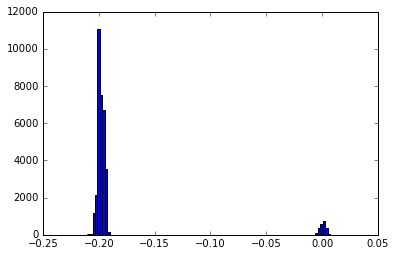

In [24]:
plt.hist(phase-np.round(phase),bins=100)
print np.sum(np.abs(phase-np.round(phase)>0.3)), "questionable entries"

In [25]:
F.derivs

{'d_DECJ': array([-113.15066, -113.1508, -113.15095, ...,  118.85497,  118.85498,
         118.85499], dtype=float128),
 'd_PMDEC': array([ 61874.24,  61874.278,  61874.316, ...,  44893.658,  44893.705,
         44893.741], dtype=float128),
 'd_PMRA': array([ 234600.09,  234600.5,  234600.9, ...,  174843.07,  174843.42,
         174843.69], dtype=float128),
 'd_PX': array([ 1.0426218e-06,  1.0426267e-06,  1.0426317e-06, ...,  1.2098231e-06,
         1.2098256e-06,  1.2098274e-06], dtype=float128),
 'd_RAJ': array([-429.01788, -429.0189, -429.01991, ...,  462.89317,  462.89367,
         462.89405], dtype=float128)}

In [26]:
F.best_parameters

{'acosi_i': 1.4917920737881377967,
 'acosi_o': 91.515517821405981132,
 'asini_i': 1.2175268187146886046,
 'asini_o': 74.672709901274213484,
 'd_DECJ': 3.8297379260835209625e-07,
 'd_RAJ': -9.1473641598984196357e-08,
 'dbeta': 3.137215781113322372e-05,
 'delta': -2.4326288381809617149e-10,
 'delta_lan': -5.4096316391090949558e-05,
 'dgamma': -2.5854449182822343408e-07,
 'eps1_i': 0.00068724728071223587401,
 'eps1_o': 0.035186247652040840626,
 'eps2_i': -9.1179836780626676656e-05,
 'eps2_o': -0.003462135260726911092,
 'f0': 365.95336311711874974,
 'f1': -2.3547358099625887817e-15,
 'j_AO1350': 5.364017648361716e-05,
 'j_AO1440': -0.00055121663140921818248,
 'j_AO327': 6.457616019511097e-05,
 'j_GBT1500': -0.00053763724410558742536,
 'j_GBT350': 1.8912917353649655e-05,
 'j_GBT820': 6.712253154451129e-05,
 'j_NCY1400': 0.000675,
 'j_WSRT350': -3.6063906052781444e-05,
 'pb_i': 1.6293969394546642386,
 'pb_o': 327.2575252205244358,
 'ppn_mode': 'heavysimple',
 'q_i': 0.13746673219074406775,
 

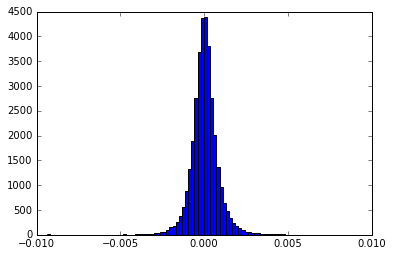

In [27]:
r = F.residuals(F.best_parameters)
plt.hist(r, bins=100);

In [47]:
d_new = d.copy()
d_new['files'] = outname
d_new

{'efac': (('AO1440', 1.45), ('GBT1500', 1.11), ('WSRT1400', 1.45)),
 'files': '0337+17-anne-2016-09-26',
 'fit_pm': False,
 'fit_pos': True,
 'fit_px': False,
 'kopeikin': False,
 'parfile': '0337_tempo2_px_optical.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'tzrmjd_middle': False}

In [53]:
F_new = threebody.Fitter(**d_new)

ValueError: Confusing tim file 0337+17-anne-2016-09-26.tim: list of 35888 telescope codes doesn't match list of 35814 BATs

In [ ]:
r = F_new.residuals(F.best_parameters)
plt.hist(r, bins=100);